In [2]:
import os
import geopandas as gpd
from glob import glob
import numpy as np
import pandas as pd 
import rasterio 
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import shutil
import sys

#execfile(os.path.join(os.getcwd(), "Functions.py"))
exec(open(os.path.join(os.getcwd(), "Functions.py")).read())

home = "/Volumes/GoogleDrive/My Drive/Chapter2_mechanisms_forest_water_cycling"

In [2]:
# list the headwater catchment files
# they are broken down by huc4, with 117,518 total
# combine into one gpd for this analysis
hws = gpd.read_file(glob(os.path.join(home, "Data", "Catchments", "Headwater", "headwater_catchments_sbr.gpkg"))[0])
hws_ids = hws['NHDPlusID']
uca = glob(os.path.join(home, "Data", "Topography", "UCA", "uca_10m_sbr.tif"))[0]

In [ ]:
# For each headwater catchment, calclate the ratio of downslope:upslope NDVI for each clear sky image 
# list all ndvi files - there are 1283
ndvi_files = glob(os.path.join(home, "Data", "NDVI","Landsat", "Landsat_images","*.tif"))
execfile(os.path.join(os.getcwd(), "Functions.py"))
uca = glob(os.path.join(home, "Data", "Topography", "UCA", "uca_10m_sbr.tif"))[0]
for id in hws_ids[0:1]:
    id = int(id)
    hw = hws[hws.NHDPlusID == id]
    catchment_ndvi_ratio_ts(hw, id, uca, ndvi_files)



In [3]:
exec(open(os.path.join(os.getcwd(), "Functions.py")).read())
ndvi_files = glob(os.path.join(home, "Data", "NDVI","Landsat", "Landsat_images","*.tif"))
uca = glob(os.path.join(home, "Data", "Topography", "UCA", "uca_10m_sbr.tif"))[0]
id = int(15000100132962.0)
hws = gpd.read_file(glob(os.path.join(home, "Data", "Catchments", "Headwater", "headwater_catchments_perm_forest_32617.shp"))[0])
hw = hws[hws.NHDPlusID == id]

boundary = hw
wsid = id 
uca = uca
ndvi_file_list = ndvi_files

In [4]:
uca_path = os.path.join(home, "Data", "Topography", "UCA","UCA_NDVI" + str(wsid))
is_exist = os.path.exists(uca_path)
if not is_exist:
    os.makedirs(uca_path)
# crop the UCA to boundary and save it to the watershed specific uca folder 
uca_path_name = os.path.join(uca_path, "uca.tif")
crop_to_boundary(uca, boundary, uca_path_name)

In [5]:
image = ndvi_file_list[359]
missing_data = check_missing_data(image, boundary['geometry'])

uca_files = glob(os.path.join(uca_path, "*.tif"))
for file in uca_files:
    check = check_metadata(file, image, missing_data[0], missing_data[1])
    if check == True: 
        matching_uca = file
        break
    else:
        matching_uca = False
    if matching_uca == False:
        uca_out = os.path.join(uca_path, "uca" + str(len(uca_files) + 1) + ".tif")
        resample_to_match_io(os.path.join(uca_path, "uca.tif"), uca_out, image, missing_data[0], missing_data[1], "bilinear")
        matching_uca = uca_out
matching_uca

'/Volumes/GoogleDrive/My Drive/Chapter2_mechanisms_forest_water_cycling/Data/Topography/UCA/UCA_NDVI15000100132962/uca2.tif'

In [14]:
uca_filepath = matching_uca
ndvi_array = missing_data[0]
uca = rasterio.open(uca_filepath, GDAL_DISABLE_READDIR_ON_OPEN=True).read(1)
# mask out no data values in the ndvi values to make sure we're not including unused pixels
ndvi = ndvi_array
mask = ndvi == -9999
uca_match = np.ma.array(uca, mask=mask)

# use the 75th percentile to designate upslope vs downslope 
q75 = np.nanquantile(uca_match.compressed(), 0.75) # this has all -9999 vlaues masked so it won't count htose in the calculation
upslope_mask = ((ndvi == -9999) | (uca >= q75))  # mask is the values you don't want 
downslope_mask =  ((ndvi == -9999) | (uca < q75))

In [15]:
ndvi_downslope = np.ma.array(ndvi_array, mask = downslope_mask)
ndvi_upslope = np.ma.array(ndvi_array, mask = upslope_mask)

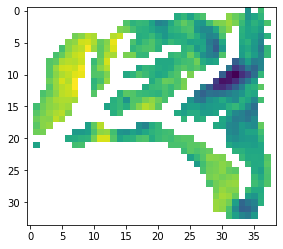

In [19]:
plt.imshow(ndvi_upslope[0,:,:], interpolation = 'none')
plt.show()

In [7]:
# make a new image that does upslope v downslope 

# where it's not masked 
uca = rasterio.open(uca_filepath, GDAL_DISABLE_READDIR_ON_OPEN=True).read(1)
mask = ndvi == -9999
uca[mask[0,:,:]] = np.nan
uca_match = uca

upslope_mask = ((uca >= q75))  # mask is the values you don't want 
downslope_mask =  ((uca < q75))

uca_match[upslope_mask] = 2
uca_match[downslope_mask] = 1


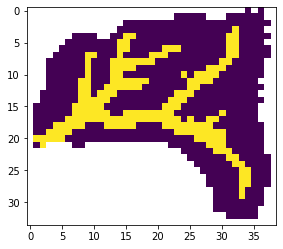

In [11]:
plt.imshow(uca_match, interpolation = 'none')
plt.show()

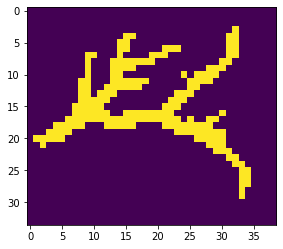

In [12]:
plt.imshow(upslope_mask, interpolation = 'none')
plt.show()

In [51]:
boundary.to_file(os.path.join(home, "boundary_example.shp"))

/Users/katiemcquillan/opt/anaconda3/envs/ch2-python-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


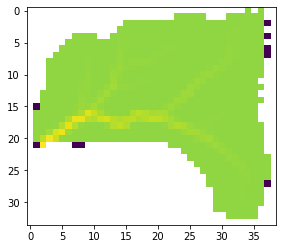

In [50]:
uca = rasterio.open(uca_filepath, GDAL_DISABLE_READDIR_ON_OPEN=True).read(1)
mask = ndvi == -9999
uca[mask[0,:,:]] = np.nan
plt.imshow(uca, interpolation = 'none')
plt.show()

TypeError: float() argument must be a string or a number, not 'Polygon'

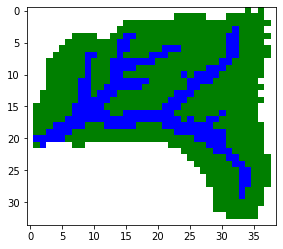

In [42]:
#plt.imshow(upslope_mask[0,:,:], interpolation = 'none')
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['g','r', 'b'])
plt.imshow(uca_match, interpolation = 'none', cmap=cmap)
plt.show()

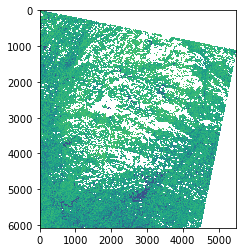

In [12]:
#np.max(np.unique(out_image))
plt.imshow(image.read(1), interpolation = 'none')
plt.show()

In [ ]:
uca_filepath = matching_uca
ndvi_array = missing_data[0]

uca = rasterio.open(uca_filepath).read(1)
# mask out no data values in the ndvi values to make sure we're not including unused pixels
ndvi = ndvi_array
mask = ndvi == -9999
uca_match = np.ma.array(uca, mask=mask)

# use the 75th percentile to designate upslope vs downslope 
q75 = np.nanquantile(uca_match.compressed(), 0.75) # this has all -9999 vlaues masked so it won't count htose in the calculation
upslope_mask = ((ndvi == -9999) | (uca >= q75))  # mask is the values you don't want 
downslope_mask =  ((ndvi == -9999) | (uca < q75))
return upslope_mask, downslope_mask